In [3]:
import intake
from easygems import healpix as egh
import healpy as hp

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
current_location = "NCAR" #"online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [6]:
from easygems.healpix import attach_coords
scream = cat['scream2D_hrly'](zoom = 7).to_dask().pipe(attach_coords)

In [74]:
domain = "East Asia"

da = (
    scream['pr']
    .sel(time=slice("2020-05-01", "2020-07-01")) #06-01 to 08-31
    .where((scream["lon"] > 105) & (scream["lon"] < 122.0) & (scream["lat"] > 20.) & (scream["lat"] < 55.), drop=True)
    .resample(time="3H") #'1D'
    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()*36e5

In [42]:
scream

<xarray.Dataset> Size: 15GB
Dimensions:   (time: 9457, cell: 196608)
Coordinates:
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    lat       (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
    lon       (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
    crs       int64 8B 0
  * cell      (cell) int64 2MB 0 1 2 3 4 ... 196603 196604 196605 196606 196607
Data variables:
    pr        (time, cell) float32 7GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    rlut      (time, cell) float32 7GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    ELEV      (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

### IFS

In [39]:
ifs = cat['ifs_tco3999-ng5_rcbmf_cf'](time='PT1H', zoom = 7).to_dask().pipe(attach_coords)

In [55]:
ifs['pr']

<xarray.DataArray 'pr' (time: 10201, cell: 196608)> Size: 8GB
dask.array<open_dataset-pr, shape=(10201, 196608), dtype=float32, chunksize=(1129, 24576), chunktype=numpy.ndarray>
Coordinates:
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
  * time     (time) datetime64[ns] 82kB 2020-01-01 ... 2021-03-01
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
Attributes: (12/14)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             196608
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   accum
    ...                         ...
    units:                      kg m-2 s-1
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [52]:
da_ifs = (
    ifs['pr']
    .sel(time=slice("2020-05-01", "2020-07-01")) #06-01 to 08-31
    .where((ifs["lon"] > 105) & (ifs["lon"] < 122.0) & (ifs["lat"] > 20.) & (ifs["lat"] < 55.), drop=True)
    .resample(time="3H") #'1D'
    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()*36e2

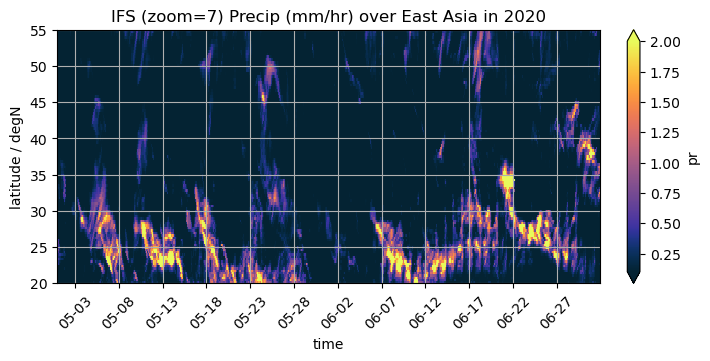

In [53]:
import nc_time_axis
import cmocean
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True)
da_ifs.plot(x="time", ax=ax, ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal)#levels=[.1,.3,.5,1.,1.2,1.5,2.]**plot_properties[var], add_colorbar=False)
ax.set_title(f"IFS (zoom=7) Precip (mm/hr) over {domain} in 2020")
ax.set_ylabel("latitude / degN")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', labelrotation=45)

### CASESM2

In [63]:
cas = cat['casesm2_10km_nocumulus'](time='PT1H', zoom = 7).to_dask().pipe(attach_coords)

In [64]:
cas

<xarray.Dataset> Size: 55GB
Dimensions:  (cell: 196608, time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2020-03-01T01:00:00 ... 2021-03-01
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables:
    orog     (cell) float32 786kB ...
    pr       (time, cell) float32 7GB ...
    psl      (time, cell) float32 7GB ...
    rlut     (time, cell) float32 7GB ...
    rsut     (time, cell) float32 7GB ...
    sftgif   (cell) float32 786kB ...
    sftlf    (cell) float32 786kB ...
    ts       (time, cell) float32 7GB ...
    u10      (time, cell) float32 7GB ...
    uas      (time, cell) float32 7GB ...
    vas      (time, cell) float32 7GB ...
Attributes: (12/13)
    Conventions:                CF-1.0
    NCO:                        netCDF Operators version 5.3.2 (Homepage = ht...
    Version:                    $Name$
    case:                       AMIP_C6NCH_fd01_no_cumulus
    history:                    Fri Feb 21 12:18:22 2025: ncks -m -A -C -v PH...
    history_of_appended_files:  Fri Feb 21 12:18:22 2025: Appended file IAP_t...
    ...                         ...
    initial_file:               /data/feikc/hindcastdata/atm_ini_0.1d_L35/IAP...
    logname:                    zhangh
    revision_Id:                $Id$
    source:                     CAM
    title:                      UNSET
    topography_file:            /data2/share/casesm/czy/plot/20250216/cube_to...

In [65]:
da_cas = (
    cas['pr']
    .sel(time=slice("2020-05-01", "2020-07-01")) #06-01 to 08-31
    .where((cas["lon"] > 105) & (cas["lon"] < 122.0) & (cas["lat"] > 20.) & (cas["lat"] < 55.), drop=True)
    .resample(time="3H") #'1D'
    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()*36e2

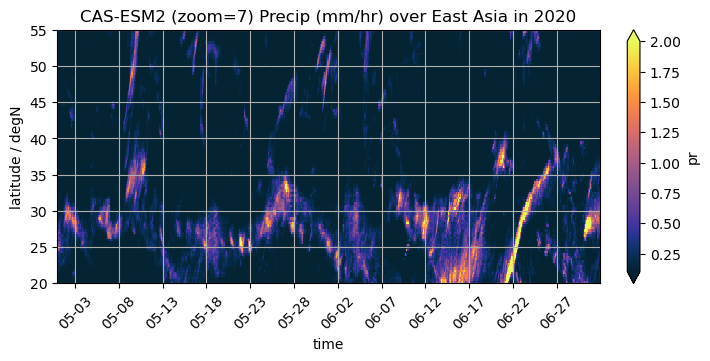

In [67]:
import nc_time_axis
import cmocean
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True)
da_cas.plot(x="time", ax=ax, ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal)#levels=[.1,.3,.5,1.,1.2,1.5,2.]**plot_properties[var], add_colorbar=False)
ax.set_title(f"CAS-ESM2 (zoom=7) Precip (mm/hr) over {domain} in 2020")
ax.set_ylabel("latitude / degN")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', labelrotation=45)

### ICON

In [58]:
icon = cat['icon_d3hp003'](time_method='inst', time='PT1H', zoom = 7).to_dask().pipe(attach_coords)

In [59]:
icon

<xarray.Dataset> Size: 56GB
Dimensions:  (cell: 196608, time: 10200)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2020-01-01T01:00:00 ... 2021-03-01
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables:
    orog     (cell) float32 786kB ...
    pr       (time, cell) float32 8GB ...
    psl      (time, cell) float32 8GB ...
    rlut     (time, cell) float32 8GB ...
    rsut     (time, cell) float32 8GB ...
    sftgif   (cell) float32 786kB ...
    sftlf    (cell) float32 786kB ...
    ts       (time, cell) float32 8GB ...
    uas      (time, cell) float32 8GB ...
    vas      (time, cell) float32 8GB ...

In [60]:
da_icon = (
    icon['pr']
    .sel(time=slice("2020-05-01", "2020-07-01")) #06-01 to 08-31
    .where((icon["lon"] > 105) & (icon["lon"] < 122.0) & (icon["lat"] > 20.) & (icon["lat"] < 55.), drop=True)
    .resample(time="3H") #'1D'
    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()*36e2

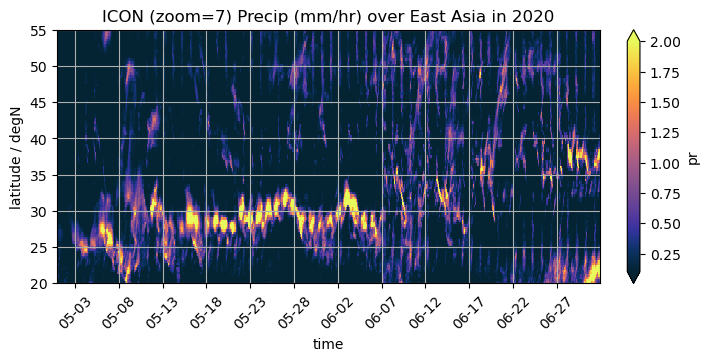

In [61]:
import nc_time_axis
import cmocean
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True)
da_icon.plot(x="time", ax=ax, ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal)#levels=[.1,.3,.5,1.,1.2,1.5,2.]**plot_properties[var], add_colorbar=False)
ax.set_title(f"ICON (zoom=7) Precip (mm/hr) over {domain} in 2020")
ax.set_ylabel("latitude / degN")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', labelrotation=45)

### UM

In [46]:
um = cat['um_glm_n1280_GAL9'](time='PT1H', zoom = 7).to_dask().pipe(attach_coords)

In [56]:
um

<xarray.Dataset> Size: 198GB
Dimensions:  (time: 10489, cell: 196608)
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables: (12/26)
    clivi    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clt      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clwvi    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hflsd    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hfssd    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    huss     (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ...       ...
    tas      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ts       (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    uas      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    vas      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    orog     (cell) float64 2MB dask.array<chunksize=(49152,), meta=np.ndarray>
    sftlf    (cell) float64 2MB dask.array<chunksize=(49152,), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n1280_GAL9_nest

In [48]:
da_um = (
    um['pr']
    .sel(time=slice("2020-05-01", "2020-07-01")) #06-01 to 08-31
    .where((um["lon"] > 105) & (um["lon"] < 122.0) & (um["lat"] > 20.) & (um["lat"] < 55.), drop=True)
    .resample(time="3H") #'1D'
    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()*36e2

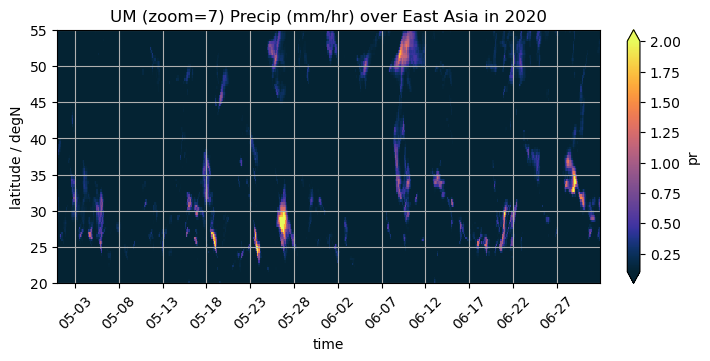

In [69]:
import nc_time_axis
import cmocean
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True)
da_um.plot(x="time", ax=ax, ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal)#levels=[.1,.3,.5,1.,1.2,1.5,2.]**plot_properties[var], add_colorbar=False)
ax.set_title(f"UM (zoom=7) Precip (mm/hr) over {domain} in 2020")
ax.set_ylabel("latitude / degN")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', labelrotation=45)

In [18]:
#import pandas as pd
#dt = pd.date_range('2020-05-01', periods=62)
#da['time']=dt
#dt = pd.date_range(start='2020-05-01', end='2020-07-01', freq='3H')

### SCREAM

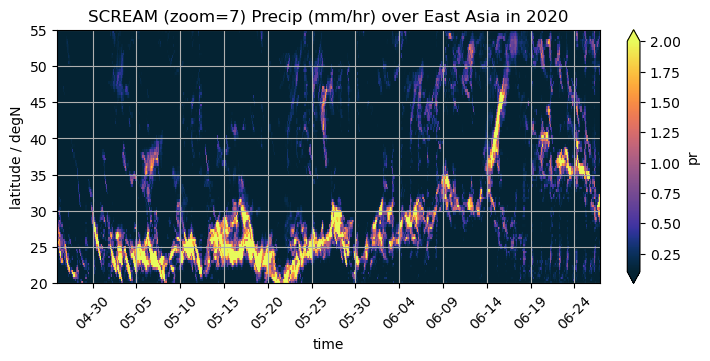

In [76]:
import nc_time_axis
import cmocean
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True)
da.plot(x="time", ax=ax, ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal)#levels=[.1,.3,.5,1.,1.2,1.5,2.]**plot_properties[var], add_colorbar=False)
ax.set_title(f"SCREAM (zoom=7) Precip (mm/hr) over {domain} in 2020")
ax.set_ylabel("latitude / degN")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', labelrotation=45)

In [27]:
scream8 = cat['scream2D_hrly'](zoom = 8).to_dask().pipe(attach_coords)
da = (
    scream8['pr']
    .sel(time=slice("2020-05-01", "2020-07-01")) #06-01 to 08-31
    .where((scream8["lon"] > 105) & (scream8["lon"] < 122.0) & (scream8["lat"] > 20.) & (scream8["lat"] < 55.), drop=True)
    .resample(time="3H")
    .mean(dim="time")
    .groupby("lat")
    .mean()
).compute()*36e5

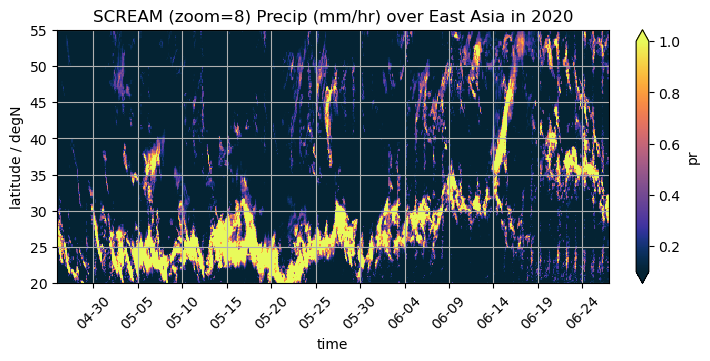

In [28]:
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True)
da.plot(x="time", ax=ax, ylim=(20.,55.), vmin=0.1, vmax=1., cmap=cmocean.cm.thermal)#levels=[.1,.3,.5,1.,1.2,1.5,2.]**plot_properties[var], add_colorbar=False)
ax.set_title(f"SCREAM (zoom=8) Precip (mm/hr) over {domain} in 2020")
ax.set_ylabel("latitude / degN")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.tick_params(axis='x', labelrotation=45)

In [100]:
def format_axes_lat(ax,nm):
    ax.set_ylabel("latitude / degN")
    ax.grid(True)
    ax.set_title(f"{nm} (zoom=7)",size=20)
    ax.set_ylabel("latitude / degN")
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel("")
    #ax.set_ylim(-90, 90)
    #ax.set_yticks([-50, -30, -10, 0, 10, 30, 50])

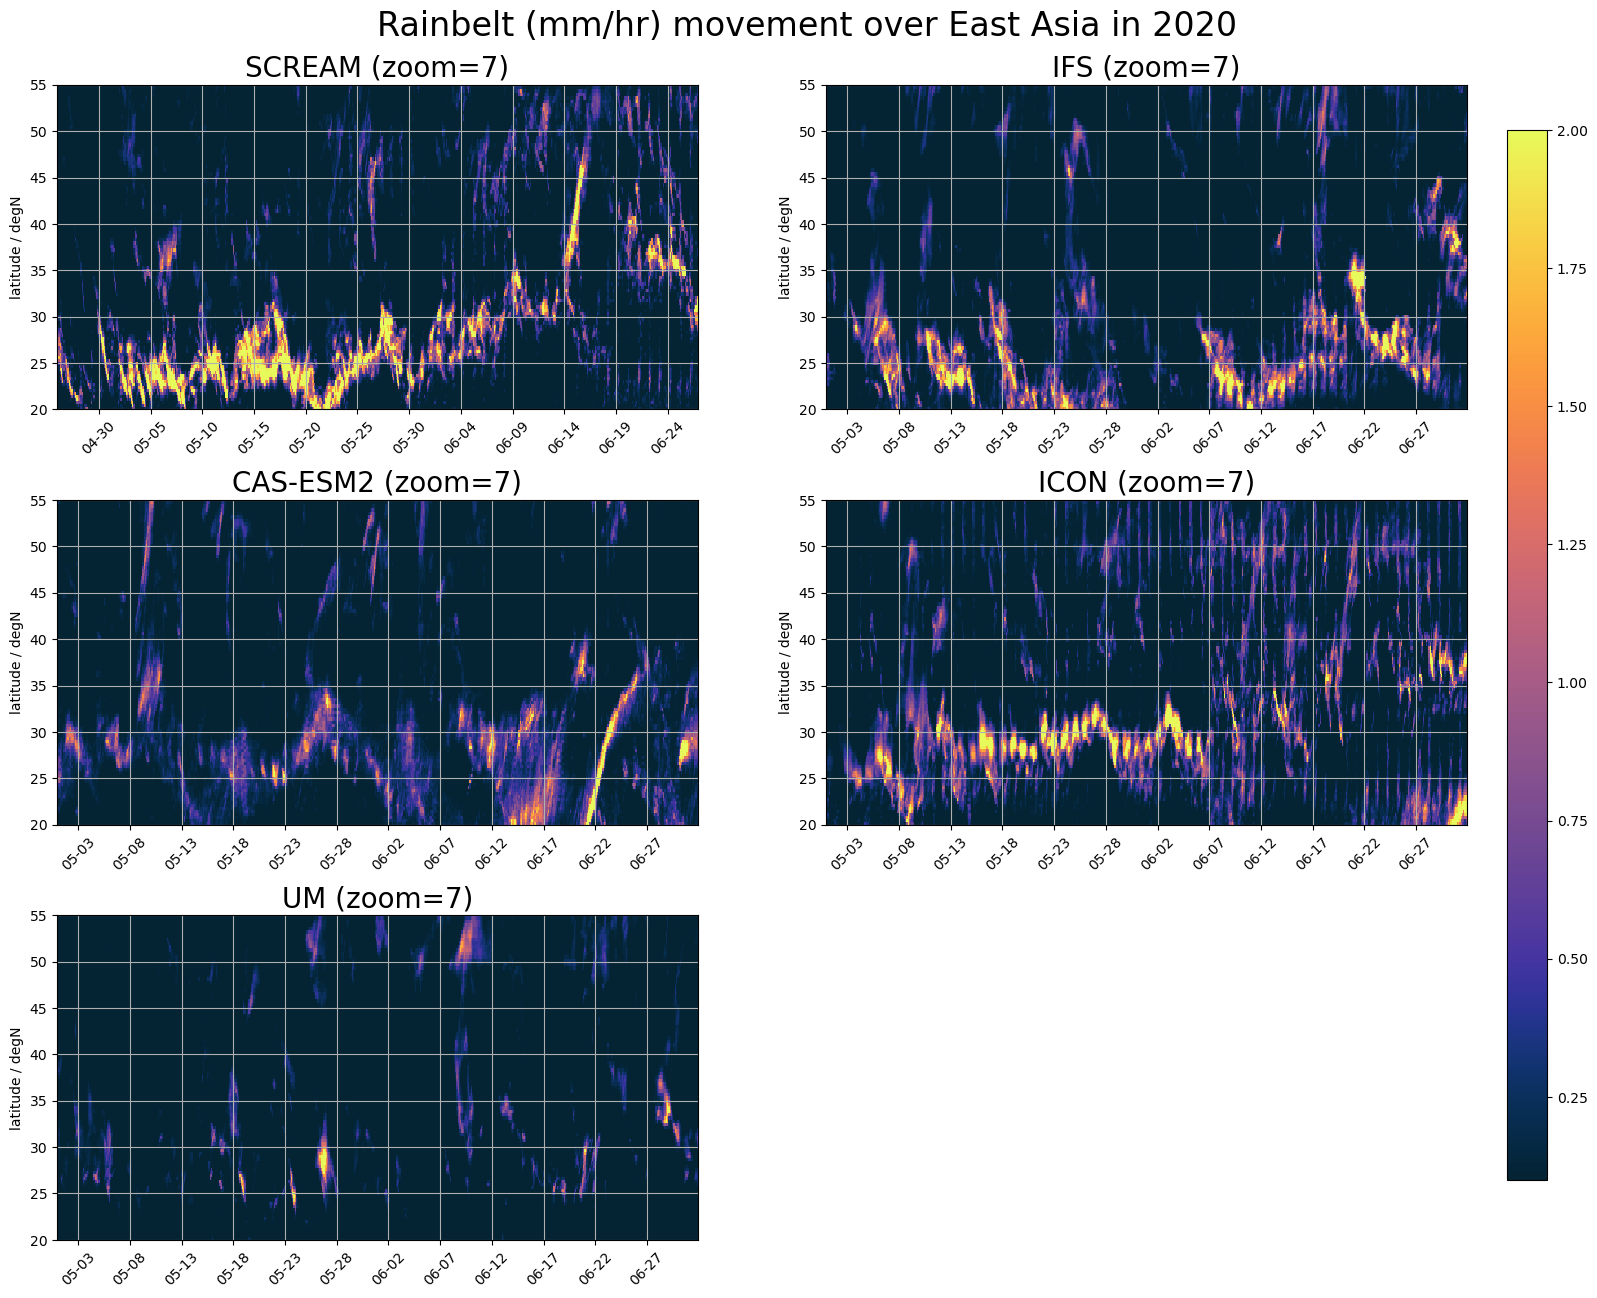

In [126]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(20, 15),
    #constrained_layout=True
)
fg = da.plot(x="time", ax=axes[0,0], ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal,add_colorbar=False)#levels=[.1,.3,.5,1.,1.2,1.5,2.], add_colorbar=False)
da_ifs.plot(x="time", ax=axes[0,1], ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal,add_colorbar=False)
da_cas.plot(x="time", ax=axes[1,0], ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal,add_colorbar=False)
da_icon.plot(x="time", ax=axes[1,1], ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal,add_colorbar=False)
da_um.plot(x="time", ax=axes[2,0], ylim=(20.,55.), vmin=0.1, vmax=2., cmap=cmocean.cm.thermal,add_colorbar=False)
format_axes_lat(axes[0,0],'SCREAM')
format_axes_lat(axes[0,1],'IFS')
format_axes_lat(axes[1,0],'CAS-ESM2')
format_axes_lat(axes[1,1],'ICON')
format_axes_lat(axes[2,0],'UM')

fig.suptitle(f'Rainbelt (mm/hr) movement over {domain} in 2020',size=24, y=0.93)
fig.subplots_adjust(right=0.83,hspace=0.28)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(fg, cax=cbar_ax)
axes[2,1].remove()